# PFCS data

## Init

In [101]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PFCS.scripts.gt_plot import read_data
from pathlib import Path
from sktime.clustering.dbscan import TimeSeriesDBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [2]:
# %matplotlib ipympl

## Get data + preprocessing

In [3]:
task_ground_truth = [
    {
        "filename": "fetch_recorded_demo_1730997119",
        "idx": {
            "plate": {"ini": 0, "end": 1125},
            "napkin": {"ini": 1125, "end": 2591},
            "cup": {"ini": 2591, "end": 3986},
            "fork": {"ini": 3986, "end": 5666},
            "spoon": {"ini": 5666, "end": 7338},
        },
    },
    {
        "filename": "fetch_recorded_demo_1730997530",
        "idx": {
            "plate": {"ini": 0, "end": 1812},
            "napkin": {"ini": 1812, "end": 3844},
            "cup": {"ini": 3844, "end": 5732},
            "fork": {"ini": 5732, "end": 7090},
            "spoon": {"ini": 7090, "end": 7955},
        },
    },
    {
        "filename": "fetch_recorded_demo_1730997735",
        "idx": {
            "plate": {"ini": 0, "end": 1965},
            "napkin": {"ini": 1965, "end": 4178},
            "cup": {"ini": 4178, "end": 6427},
            "spoon": {"ini": 6427, "end": 7904},
            "fork": {"ini": 7904, "end": 9123},
        },
    },
    {
        "filename": "fetch_recorded_demo_1730997956",
        "idx": {
            "plate": {"ini": 0, "end": 1898},
            "napkin": {"ini": 1898, "end": 4081},
            "cup": {"ini": 4081, "end": 5442},
            "spoon": {"ini": 5442, "end": 6829},
            "fork": {"ini": 6829, "end": 9177},
        },
    },
]

In [4]:
# # path = './PFCS/table task/xyz data/full_tasks/fetch_recorded_demo_1730997119.txt'
# xyz_path = Path("./PFCS/table task/xyz data/full_tasks/fetch_recorded_demo_1730997956.txt")
# # h5_path = './PFCS/table task/h5 files/fetch_recorded_demo_1730997119.h5'
# h5_path = Path("./PFCS/table task/h5 files/fetch_recorded_demo_1730997956.h5")

filenum = 0
datapath_root = Path("./PFCS/table task")
xyz_path = (
    datapath_root
    / "xyz data"
    / "full_tasks"
    / (task_ground_truth[filenum]["filename"] + ".txt")
)
h5_path = datapath_root / "h5 files" / (task_ground_truth[filenum]["filename"] + ".h5")

In [5]:
data = np.loadtxt(xyz_path)  # load the file into an array

# x = data[:, 0]
# y = data[:, 1]
# z = data[:, 2]

joint_data, tf_data, gripper_data = read_data(h5_path)
# time = tf_data[0][:, 0] + tf_data[0][:, 1] * (10.0 ** -9)

# traj_list = [x, y, z]
# traj = data
# traj.shape

In [6]:
# nanosec_conv = 1e-9
time_sec = tf_data[0][:, 0]
time_nanosec = tf_data[0][:, 1]
# time = time_sec + time_nanosec * nanosec_conv

In [7]:
timestamps = []
for t_idx, t_val in enumerate(time_sec):
    timestamp = pd.Timestamp(time_sec[t_idx], unit="s", tz="EST") + pd.to_timedelta(
        time_nanosec[t_idx], unit="ns"
    )
    timestamps.append(timestamp)
timestamps = pd.Series(timestamps)
timestamps

0      2024-11-07 11:31:59.503861904-05:00
1      2024-11-07 11:31:59.533841848-05:00
2      2024-11-07 11:31:59.553872347-05:00
3      2024-11-07 11:31:59.553872347-05:00
4      2024-11-07 11:31:59.583873749-05:00
                       ...                
7333   2024-11-07 11:34:42.413918734-05:00
7334   2024-11-07 11:34:42.443821907-05:00
7335   2024-11-07 11:34:42.473963261-05:00
7336   2024-11-07 11:34:42.503791571-05:00
7337   2024-11-07 11:34:42.523845196-05:00
Length: 7338, dtype: datetime64[ns, EST]

In [8]:
traj = pd.DataFrame(
    {"x": data[:, 0], "y": data[:, 1], "z": data[:, 2], "timestamps": timestamps}
)
traj

,x,y,z,timestamps
0,0.425767,0.243364,0.976381,2024-11-07 11:31:59.503861904-05:00
1,0.425373,0.243382,0.976542,2024-11-07 11:31:59.533841848-05:00
2,0.425282,0.243515,0.976639,2024-11-07 11:31:59.553872347-05:00
3,0.425282,0.243515,0.976639,2024-11-07 11:31:59.553872347-05:00
4,0.425350,0.243331,0.976105,2024-11-07 11:31:59.583873749-05:00
...,...,...,...,...
7333,0.662908,0.221483,1.031193,2024-11-07 11:34:42.413918734-05:00
7334,0.662635,0.221682,1.031233,2024-11-07 11:34:42.443821907-05:00
7335,0.662784,0.222090,1.030785,2024-11-07 11:34:42.473963261-05:00
7336,0.662740,0.221329,1.030948,2024-11-07 11:34:42.503791571-05:00


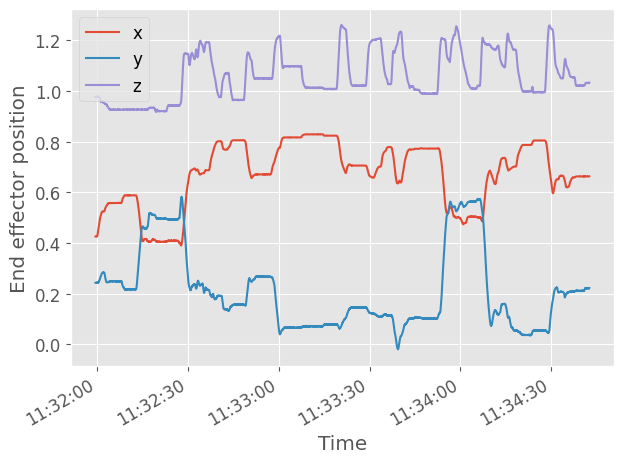

In [9]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(timestamps, traj.x, label="x")  # , color=cmap[0])
    ax.plot(timestamps, traj.y, label="y")  # , color=cmap[1])
    ax.plot(timestamps, traj.z, label="z")  # , color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

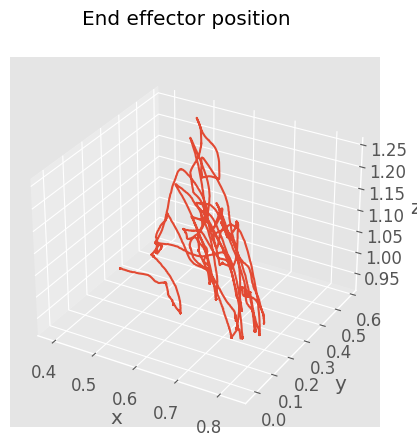

In [10]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.suptitle("End effector position")
    ax.plot(traj.x, traj.y, traj.z)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.show()

## Ground truth segmentation

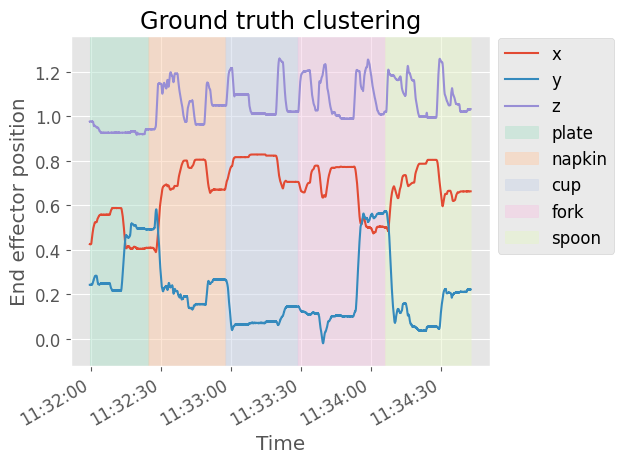

In [11]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(timestamps, traj.x, label="x")  # , color=cmap[0])
    ax.plot(timestamps, traj.y, label="y")  # , color=cmap[1])
    ax.plot(timestamps, traj.z, label="z")  # , color=cmap[2])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max()])
    for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
        sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
        x = timestamps[sect_dict_current["ini"] : sect_dict_current["end"]]
        ax.fill_between(
            x=x,
            y1=fill_min,
            y2=fill_max,
            color=cmap[sect_i],
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

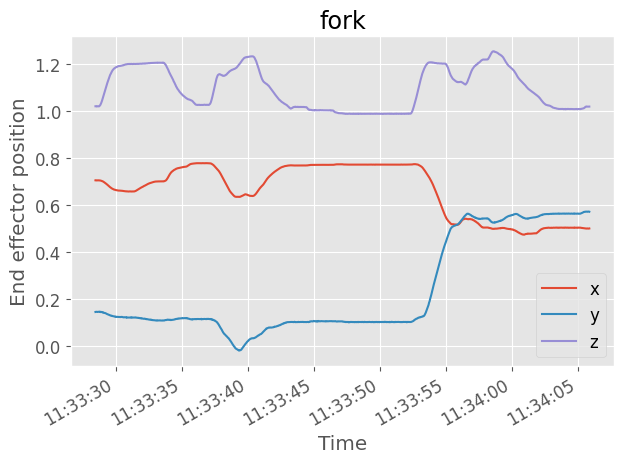

In [12]:
sect_key = "fork"
sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]

with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(
        timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.x[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="x",
    )  # , color=cmap[0])
    ax.plot(
        timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.y[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="y",
    )  # , color=cmap[1])
    ax.plot(
        timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.z[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="z",
    )  # , color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    ax.set_title(sect_key)
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [38]:
traj.z[sect_dict_current["ini"] : sect_dict_current["end"]]

5666    1.019620
5667    1.019619
5668    1.019078
5669    1.019078
5670    1.020749
          ...   
7333    1.031193
7334    1.031233
7335    1.030785
7336    1.030948
7337    1.031934
Name: z, Length: 1672, dtype: float64

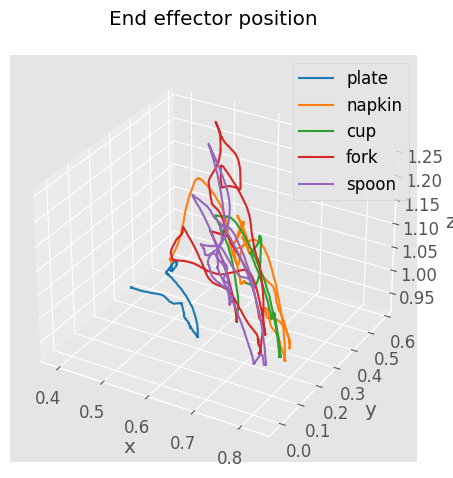

In [13]:
with plt.style.context("ggplot_perso.mplstyle"):
    cmap = mpl.colormaps.get("tab10").colors
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.suptitle("End effector position")

    for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
        sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
        ax.plot(
            traj.x[sect_dict_current["ini"] : sect_dict_current["end"]],
            traj.y[sect_dict_current["ini"] : sect_dict_current["end"]],
            traj.z[sect_dict_current["ini"] : sect_dict_current["end"]],
            color=cmap[sect_i],
            label=sect_key,
        )
    ax.legend(loc="best")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    fig.tight_layout()
    plt.show()

## Segmentation

### TimeSeriesDBSCAN

In [86]:
X = traj.to_numpy()[:, 0:3]
X

array([[0.42576695065608255, 0.24336408706793747, 0.9763806255759524],
       [0.425372503326591, 0.24338175869313855, 0.9765416710153978],
       [0.4252818198017751, 0.24351547298932658, 0.9766390753367578],
       ...,
       [0.6627840022786337, 0.22209013239579103, 1.0307851312729586],
       [0.6627395384008897, 0.22132938309932987, 1.030948419129977],
       [0.662997772276541, 0.2221415054054696, 1.0319335124412465]],
      shape=(7338, 3), dtype=object)

In [80]:
tsdbscan = TimeSeriesDBSCAN(distance=pairwise_distances)

In [ ]:
tsdbscan.fit(X=X)

### DBSCAN

In [100]:
db = DBSCAN(eps=0.05, min_samples=500).fit(X=X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 3383


In [150]:
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

NameError: name 'labels_true' is not defined

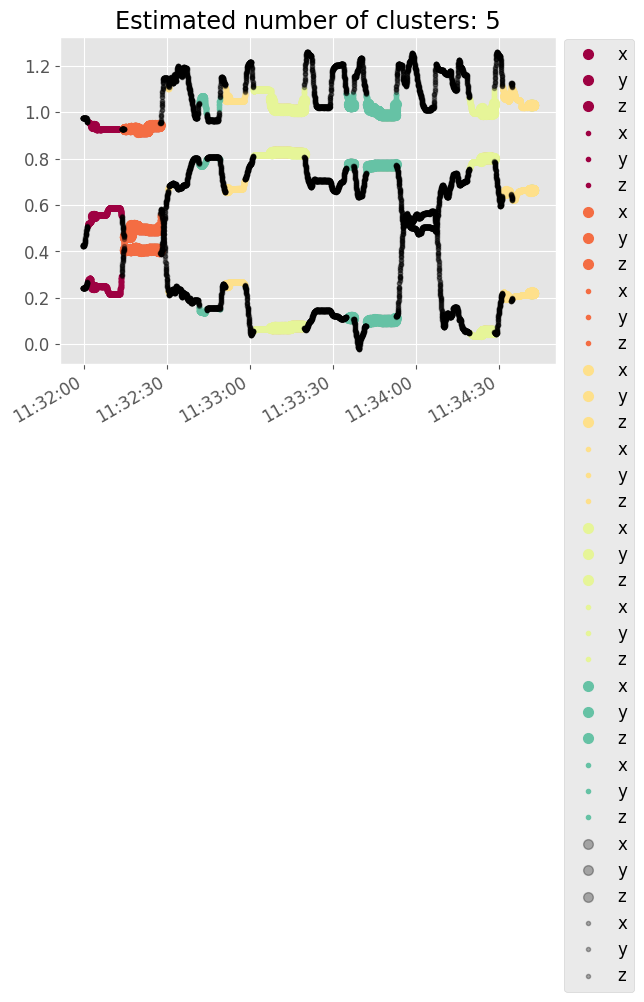

In [149]:
with plt.style.context("ggplot_perso.mplstyle"):
    # cmap = mpl.colormaps.get("tab10").colors
    fig, ax = plt.subplots()
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        alpha = 1
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            alpha = 0.3

        class_member_mask = labels == k

        # xy = X[class_member_mask & core_samples_mask]
        # ax.plot(
        #     xy[:, 0],
        #     xy[:, 1],
        #     "o",
        #     markerfacecolor=tuple(col),
        #     markeredgecolor="k",
        #     markersize=14,
        # )

        # xy = X[class_member_mask & ~core_samples_mask]
        # ax.plot(
        #     xy[:, 0],
        #     xy[:, 1],
        #     "o",
        #     markerfacecolor=tuple(col),
        #     markeredgecolor="k",
        #     markersize=6,
        # )
        ax.plot(
            timestamps[class_member_mask & core_samples_mask],
            traj.x[class_member_mask & core_samples_mask],
            # X[class_member_mask & core_samples_mask][:, 0],
            "o",
            label="x",
            markerfacecolor=tuple(col),
            markeredgecolor=tuple(col),
            markersize=7,
            alpha=alpha,
        )  # , color=cmap[0])
        ax.plot(
            timestamps[class_member_mask & core_samples_mask],
            traj.y[class_member_mask & core_samples_mask],
            # X[class_member_mask & core_samples_mask][:, 1],
            "o",
            label="y",
            markerfacecolor=tuple(col),
            markeredgecolor=tuple(col),
            markersize=7,
            alpha=alpha,
        )  # , color=cmap[1])
        ax.plot(
            timestamps[class_member_mask & core_samples_mask],
            traj.z[class_member_mask & core_samples_mask],
            # X[class_member_mask & core_samples_mask][:, 2],
            "o",
            label="z",
            markerfacecolor=tuple(col),
            markeredgecolor=tuple(col),
            markersize=7,
            alpha=alpha,
        )  # , color=cmap[2])

        ax.plot(
            timestamps[class_member_mask & ~core_samples_mask],
            traj.x[class_member_mask & ~core_samples_mask],
            # X[class_member_mask & ~core_samples_mask][:, 0],
            "o",
            label="x",
            markerfacecolor=tuple(col),
            markeredgecolor=tuple(col),
            markersize=3,
            alpha=alpha,
        )  # , color=cmap[0])
        ax.plot(
            timestamps[class_member_mask & ~core_samples_mask],
            traj.y[class_member_mask & ~core_samples_mask],
            # X[class_member_mask & ~core_samples_mask][:, 1],
            "o",
            label="y",
            markerfacecolor=tuple(col),
            markeredgecolor=tuple(col),
            markersize=3,
            alpha=alpha,
        )  # , color=cmap[1])
        ax.plot(
            timestamps[class_member_mask & ~core_samples_mask],
            traj.z[class_member_mask & ~core_samples_mask],
            # X[class_member_mask & ~core_samples_mask][:, 2],
            "o",
            label="z",
            markerfacecolor=tuple(col),
            markeredgecolor=tuple(col),
            markersize=3,
            alpha=alpha,
        )  # , color=cmap[2])

    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title(f"Estimated number of clusters: {n_clusters_}")
    fig.autofmt_xdate()
    # fig.tight_layout()
    plt.show()